<a href="https://colab.research.google.com/github/Cyberpradeep/Final_Project/blob/main/garbage2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt


In [4]:
img_size = (224, 224)
batch_size = 32

data_path = '/content/drive/MyDrive/garbage2/TrashType_Image_Dataset'

train_ds = image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes found:", class_names)


Found 2559 files belonging to 6 classes.
Using 2048 files for training.
Found 2559 files belonging to 6 classes.
Using 511 files for validation.
Classes found: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


In [7]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)


base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

# Connect the output of the base model to the subsequent layers
x = base_model(x)  # Pass the output of the previous layer (rescaled and augmented) to the base model
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
]


In [10]:
from sklearn.utils import class_weight
import numpy as np

labels = []
for images, lbls in train_ds.unbatch():
    labels.append(lbls.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights_dict = {i : class_weights[i] for i in range(len(class_names))}
print(class_weights_dict)


{0: np.float64(1.0502564102564103), 1: np.float64(0.8469809760132341), 2: np.float64(1.003921568627451), 3: np.float64(0.7052341597796143), 4: np.float64(0.8819982773471146), 5: np.float64(3.1314984709480123)}


In [11]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.2629 - loss: 2.3357 - val_accuracy: 0.5695 - val_loss: 1.2116 - learning_rate: 1.0000e-04
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.4359 - loss: 1.5631 - val_accuracy: 0.6556 - val_loss: 0.9389 - learning_rate: 1.0000e-04
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.5701 - loss: 1.2227 - val_accuracy: 0.7006 - val_loss: 0.8060 - learning_rate: 1.0000e-04
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.5990 - loss: 1.1083 - val_accuracy: 0.7456 - val_loss: 0.7204 - learning_rate: 1.0000e-04
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6275 - loss: 1.0225 - val_accuracy: 0.7671 - val_loss: 0.6818 - learning_rate: 1.0000e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.6591 - loss: 0.9358 - val_accuracy: 0.7730 - val_loss: 0.6484 - learning_rate: 1.0000e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.6656 

In [12]:
#Fine tune
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=callbacks)



Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 495s 7s/step - accuracy: 0.5192 - loss: 1.3501 - val_accuracy: 0.8395 - val_loss: 0.4845 - learning_rate: 1.0000e-05
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 449s 7s/step - accuracy: 0.5931 - loss: 1.1075 - val_accuracy: 0.8297 - val_loss: 0.5065 - learning_rate: 1.0000e-05
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 501s 7s/step - accuracy: 0.6106 - loss: 1.0746 - val_accuracy: 0.8239 - val_loss: 0.5337 - learning_rate: 1.0000e-05
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 452s 7s/step - accuracy: 0.6532 - loss: 0.9773 - val_accuracy: 0.8200 - val_loss: 0.5379 - learning_rate: 3.0000e-06
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 452s 7s/step - accuracy: 0.6674 - loss: 0.9066 - val_accuracy: 0.8141 - val_loss: 0.5409 - learning_rate: 3.0000e-06


In [13]:
model.save('/content/drive/MyDrive/garbage_classifier_224_finetuned.h5')


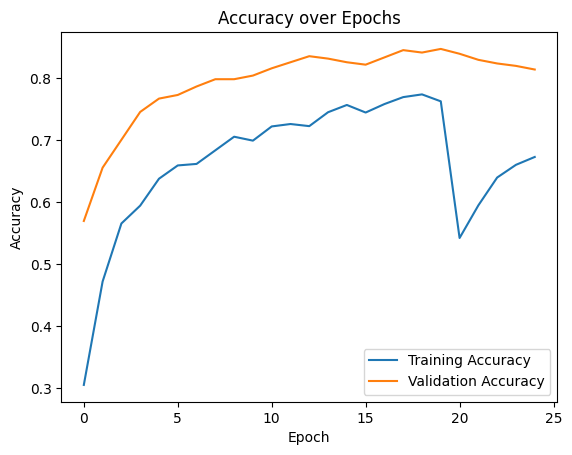

In [14]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



## Evaluate the model




**Reasoning**:
Evaluate the model on the validation dataset and print the results.



In [15]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8295 - loss: 0.4840
Validation Loss: 0.4845
Validation Accuracy: 0.8395


## Visualize predictions




**Reasoning**:
Visualize a batch of images from the validation set with their true and predicted labels to understand the model's performance qualitatively.



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


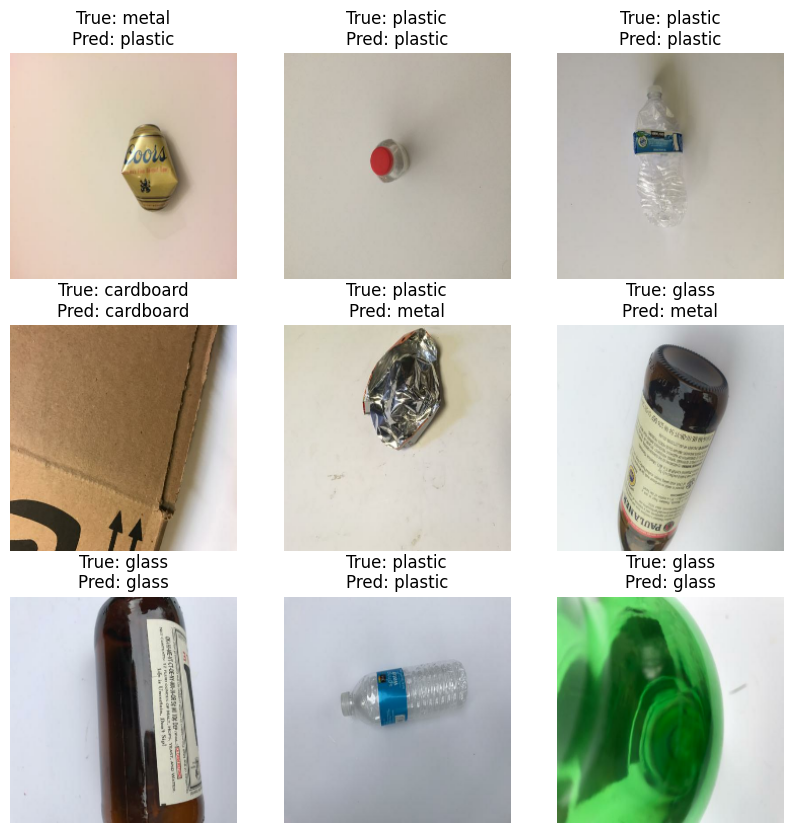

In [16]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the validation dataset
for images, labels in val_ds.take(1):
    # Make predictions on the batch
    predictions = model.predict(images)

    # Display a few images with true and predicted labels
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        predicted_label = class_names[np.argmax(predictions[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")
    plt.show()

## Inspect data and preprocessing




**Reasoning**:
Inspect the data loading, augmentation, and preprocessing steps as outlined in the instructions.



In [17]:
# 1. Inspect image_dataset_from_directory calls
print("Training dataset configuration:")
print(f"  Subset: training")
print(f"  Seed: 123")
print(f"  Image size: {img_size}")
print(f"  Batch size: {batch_size}")
print("\nValidation dataset configuration:")
print(f"  Subset: validation")
print(f"  Seed: 123")
print(f"  Image size: {img_size}")
print(f"  Batch size: {batch_size}")

# 2. Examine data_augmentation layer
print("\nData augmentation layers:")
for layer in data_augmentation.layers:
    print(f"  - {layer.name}: {layer.get_config()}")

# 3. Check Rescaling layer in the model definition
print("\nModel preprocessing layers:")
# Assuming the first two layers after input are data_augmentation and Rescaling
print(f"  - {model.layers[1].name}: {model.layers[1].get_config()}")
print(f"  - {model.layers[2].name}: {model.layers[2].get_config()}")


# 4. Consider cache() and prefetch() operations
print("\nDataset caching and prefetching:")
print(f"  train_ds: {train_ds}")
print(f"  val_ds: {val_ds}")

# 5. Verify class_weights_dict computation (already done in a previous cell)
print("\nClass weights dictionary (computed previously):")
print(class_weights_dict)

Training dataset configuration:
  Subset: training
  Seed: 123
  Image size: (224, 224)
  Batch size: 32

Validation dataset configuration:
  Subset: validation
  Seed: 123
  Image size: (224, 224)
  Batch size: 32

Data augmentation layers:
  - random_flip: {'name': 'random_flip', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'seed': None, 'mode': 'horizontal', 'data_format': 'channels_last'}
  - random_rotation: {'name': 'random_rotation', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'factor': (-0.2, 0.2), 'data_format': 'channels_last', 'fill_mode': 'reflect', 'fill_value': 0.0, 'interpolation': 'bilinear', 'seed': None}
  - random_zoom: {'name': 'random_zoom', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'height_factor':

## Analyze model architecture and training




**Reasoning**:
Print the model summary and plot the training history to analyze the architecture and identify potential issues like overfitting or underfitting.



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,210,196 (27.50 MB)

 Trainable params: 2,391,174 (9.12 MB)

 Non-trainable params: 36,672 (143.25 KB)

 Optimizer params: 4,782,350 (18.24 MB)

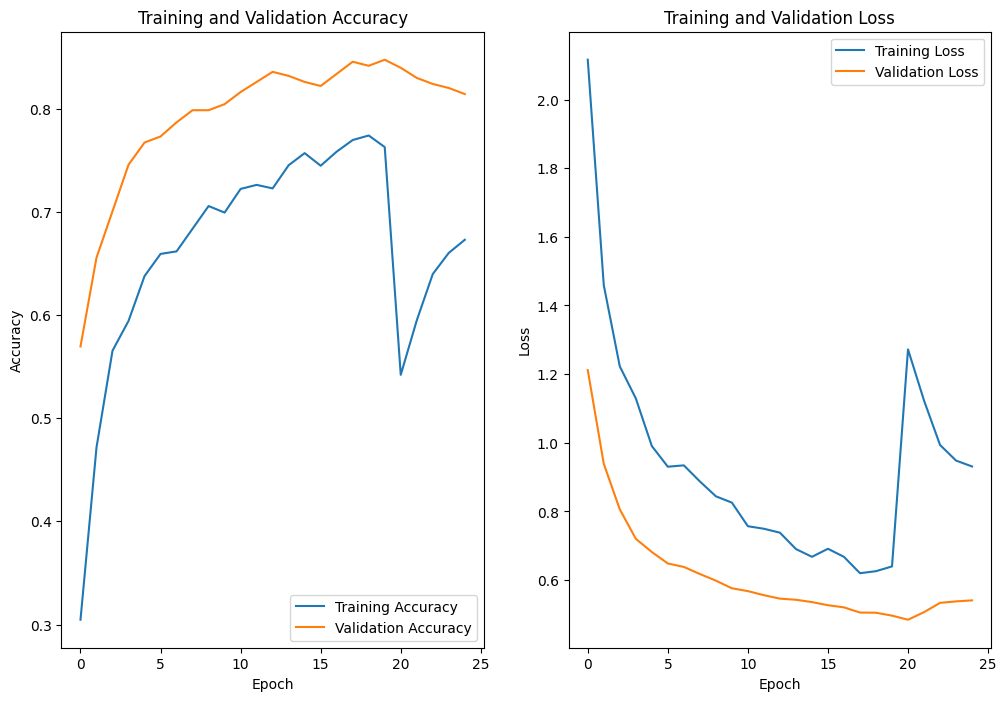


Hyperparameters and Callbacks used:
Optimizer: Adam
Initial Learning Rate (initial training): 1e-4
Learning Rate (fine-tuning): 1e-5
Callbacks:
  - EarlyStopping: monitor='val_loss', patience=4, restore_best_weights=True
  - ReduceLROnPlateau: monitor='val_loss', factor=0.3, patience=2


In [18]:
# 1. Print model summary
model.summary()

# 2. Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Extend with fine-tuning history if available
if 'history_fine' in locals():
    acc.extend(history_fine.history['accuracy'])
    val_acc.extend(history_fine.history['val_accuracy'])
    loss.extend(history_fine.history['loss'])
    val_loss.extend(history_fine.history['val_loss'])


epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 3. Review hyperparameters and callbacks (already defined in previous cells, we can just print a reminder)
print("\nHyperparameters and Callbacks used:")
print("Optimizer: Adam")
print("Initial Learning Rate (initial training): 1e-4")
print("Learning Rate (fine-tuning): 1e-5")
print("Callbacks:")
print("  - EarlyStopping: monitor='val_loss', patience=4, restore_best_weights=True")
print("  - ReduceLROnPlateau: monitor='val_loss', factor=0.3, patience=2")

## Refine model


**Reasoning**:
Based on the overfitting observed in the previous step, I will recompile the model with the same fine-tuning optimizer and learning rate, but train for fewer epochs with the existing EarlyStopping callback to prevent overfitting.



In [19]:
# Recompile the model with the same fine-tuning settings
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model for a reduced number of epochs with callbacks and class weights
# The EarlyStopping callback will stop training when val_loss starts increasing
history_adjusted = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights_dict  # Add class weights here
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 490s 7s/step - accuracy: 0.6067 - loss: 1.2941 - val_accuracy: 0.8258 - val_loss: 0.5004 - learning_rate: 1.0000e-05
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 503s 7s/step - accuracy: 0.6198 - loss: 1.2531 - val_accuracy: 0.8356 - val_loss: 0.5135 - learning_rate: 1.0000e-05
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 504s 7s/step - accuracy: 0.6348 - loss: 1.1461 - val_accuracy: 0.8376 - val_loss: 0.5102 - learning_rate: 1.0000e-05
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 509s 7s/step - accuracy: 0.6631 - loss: 1.0573 - val_accuracy: 0.8219 - val_loss: 0.5168 - learning_rate: 3.0000e-06
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 495s 7s/step - accuracy: 0.6755 - loss: 1.0299 - val_accuracy: 0.8200 - val_loss: 0.5189 - learning_rate: 3.0000e-06


## Evaluate refined model

**Reasoning**:
Evaluate the refined model on the validation dataset and print the results to see if the changes improved performance.

In [20]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8173 - loss: 0.4950
Validation Loss: 0.5004
Validation Accuracy: 0.8258


In [25]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.image import resize
from PIL import Image
import os

def classify_garbage(img):
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)

    # Preprocess the image
    img = img.convert('RGB') # Ensure image is in RGB format
    img = image.img_to_array(img)
    # Resize the image to the expected input size of the model
    img = resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Rescale the image


    predictions = model.predict(img)
    score = tf.nn.softmax(predictions[0])

    return {class_names[i]: float(score[i]) for i in range(len(class_names))}

image_input = gr.Image(type="pil")
label_output = gr.Label()

sample_images = [
    os.path.join(data_path, 'cardboard', os.listdir(os.path.join(data_path, 'cardboard'))[0]),
    os.path.join(data_path, 'glass', os.listdir(os.path.join(data_path, 'glass'))[0]),
    os.path.join(data_path, 'metal', os.listdir(os.path.join(data_path, 'metal'))[0]),
    os.path.join(data_path, 'paper', os.listdir(os.path.join(data_path, 'paper'))[0]),
    os.path.join(data_path, 'plastic', os.listdir(os.path.join(data_path, 'plastic'))[0]),
    os.path.join(data_path, 'trash', os.listdir(os.path.join(data_path, 'trash'))[0]),
]


interface = gr.Interface(
    fn=classify_garbage,
    inputs=image_input,
    outputs=label_output,
    title="Garbage Classification",
    description="Classify images of garbage into one of six categories: cardboard, glass, metal, paper, plastic, trash.",
    examples=sample_images # Add sample images here
)

interface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f93959e3080694fe1c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f93959e3080694fe1c.gradio.live
